In [45]:

from astropy.table import Table, join
from astropy.cosmology import Planck18 as cosmo
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from scipy.optimize import minimize
from scipy.special import erfc

import numpy as np
import matplotlib.colors as colors
import sncosmo
import lcdata

import parsnip

In [46]:
#Load the model
model = parsnip.load_model('../parsnip-mod/models/model_real_final.pt')
#Load the dataset
ps_dataset_raw = lcdata.read_hdf5('../lc_data/ps_data.h5')
ps_dataset = model.preprocess(ps_dataset_raw)
ps_train, ps_test = parsnip.split_train_test(ps_dataset)

Preprocessing dataset: 100%|██████████| 266/266 [00:00<00:00, 433.75it/s]


In [47]:
ps_predictions = model.predict_dataset(ps_dataset)

Length (128,) for reference_time
Length (128,) for reference_time_error
Length (128,) for color
Length (128,) for color_error
Length (128,) for amplitude
Length (128,) for amplitude_error
Length (128,) for s1
Length (128,) for s1_error
Length (128,) for s2
Length (128,) for s2_error
Length (128,) for s3
Length (128,) for s3_error
Length (128,) for total_s2n
Length (128,) for count
Length (128,) for count_s2n_3
Length (128,) for count_s2n_5
Length (128,) for count_s2n_3_pre
Length (128,) for count_s2n_3_rise
Length (128,) for count_s2n_3_fall
Length (128,) for count_s2n_3_post
Length (128,) for model_chisq
Length (128,) for model_dof
22
1
Length (128,) for reference_time
Length (128,) for reference_time_error
Length (128,) for color
Length (128,) for color_error
Length (128,) for amplitude
Length (128,) for amplitude_error
Length (128,) for s1
Length (128,) for s1_error
Length (128,) for s2
Length (128,) for s2_error
Length (128,) for s3
Length (128,) for s3_error
Length (128,) for tota

In [48]:
ps_predictions

object_id,ra,dec,type,redshift,z_CMB,MWEBV,parsnip_reference_time,parsnip_scale,reference_time,reference_time_error,color,color_error,amplitude,amplitude_error,s1,s1_error,s2,s2_error,s3,s3_error,total_s2n,count,count_s2n_3,count_s2n_5,count_s2n_3_pre,count_s2n_3_rise,count_s2n_3_fall,count_s2n_3_post,model_chisq,model_dof,luminosity,luminosity_error
str21,float64,float64,str4,float64,float64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,float32,int64,float64,float32
lcdata_kgejmv_0000535,159.9850917,58.4149167,SNIa,0.0713,0.07184531841096797,0.004700323784702943,56030.223321918274,434.7617,55982.06001854303,2.8548454e-06,-0.31746328,9.771703e-07,55074.75,171.08932,4.634856,5.993802e-07,0.5797848,1.38929945e-05,-0.9790031,2.781528e-08,360.09805,168,49,49,0,0,17,32,26045.934,162,-24.462913886388492,0.0033728234
lcdata_kgejmv_0000536,334.1344458,0.4732944,SNIa,0.1384,0.13704191207054817,0.04712365776474952,55821.37996383681,127.16887,55768.47622009291,9.826883e-06,0.023825653,1.1060722e-05,42419.668,161.1138,-0.14378929,6.5137545e-05,-0.22385196,2.013534e-05,-0.7696402,3.9153124e-07,283.8398,167,58,57,0,0,19,39,11239.754,161,-25.715570606294634,0.004123752
lcdata_kgejmv_0000537,35.3240875,-2.949125,SNIa,0.2641,0.26305883902759697,0.019712351251884398,55863.44164203102,29.621319,55816.87979052956,0.12689148,-0.06637906,0.014551809,1070.4148,26.999825,1.007652,0.104400784,-0.06447677,0.09882377,-0.7173123,0.004379065,44.829254,159,29,18,0,0,11,18,437.82306,153,-23.280901427333255,0.02739213
lcdata_kgejmv_0000538,244.4513708,54.6333833,SNIa,0.308,0.30805757426074454,0.007585017806426513,56458.44587728292,20.018803,56404.141666620075,0.13556594,-0.029334808,0.012736395,792.3625,11.609275,1.107107,0.110316716,0.040782917,0.092344575,-0.705878,0.005375914,68.81035,177,46,39,0,0,9,37,76.04128,171,-23.33718362994837,0.015908746
lcdata_kgejmv_0000539,162.029425,56.8501528,SNIa,0.2449,0.2455750101901264,0.005621059780081818,55215.506076545105,31.212194,55164.51873371063,0.014037484,-0.03203288,0.0017404604,1445.3088,16.894957,1.5281713,0.013055456,-0.14680137,0.015315728,-0.6769255,0.00064396905,87.90755,182,48,37,0,0,15,33,408.98132,176,-23.420711161273253,0.012692306
lcdata_kgejmv_0000540,131.3375208,44.7547944,SNIa,0.3316,0.3323907743895771,0.02042050120287709,56302.411491423176,25.806295,56250.294445066975,0.56773186,-0.0030591276,0.018983454,1285.1987,19.142178,1.2018392,0.13679117,0.4392712,0.1385984,-0.73709565,0.02522209,67.92156,181,42,27,0,0,5,37,105.33115,175,-24.047793475807524,0.016172517
lcdata_kgejmv_0000541,333.949,-0.3155167,SNIa,0.2455,0.24401788655698997,0.06285535958009013,56174.41541889757,30.49146,56128.9008734569,0.58720297,0.032762416,0.02655974,1983.7632,41.891705,1.0507725,0.17551287,0.17094119,0.13823786,-0.72288465,0.026279476,48.703506,139,27,20,0,0,9,18,129.41545,133,-23.770553174114518,0.022931226
lcdata_kgejmv_0000542,241.4368042,56.0744167,SNIa,0.3283,0.3283939561618896,0.006300918962576489,55363.443895260345,18.082819,55303.27622787143,0.43245754,0.08548135,0.02758379,620.30426,17.892939,1.2030784,0.24800166,0.48446316,0.22064312,-0.6905197,0.01752865,35.26355,161,22,14,0,0,6,16,41.602165,155,-23.231686495085498,0.031327218
lcdata_kgejmv_0000543,54.0720875,-28.0515111,SNIa,0.1396,0.13917941930220712,0.007911200886650562,55500.47096472195,95.43467,55444.20705633572,0.0019367922,0.006644376,0.0005378552,8895.905,81.667175,1.1900932,0.0038358837,-0.14039138,0.0029039555,-0.868942,7.057194e-05,159.67178,165,46,36,0,0,14,32,13629.339,159,-24.040007494191705,0.009967673


In [49]:
def probe_reconstruction(dataset, model, threshold=0.05):
    loader = model.get_data_loader(dataset)
    
    mag_err = []
    mag_diff = []
    
    for batch_lcs in loader:
        result = model.forward(batch_lcs, to_numpy=True, sample=False)
        
        obs_flux = result['obs_flux']
        obs_fluxerr = result['obs_fluxerr']
        model_flux = result['model_flux']

        # Cut out very low signal-to-noise measurements that will mess up the
        # conversion to magnitudes. We impose a magnitude cut later anyway, so this
        # won't impact the final result.
        cut = (obs_fluxerr > 0) & (obs_flux > 0) & (obs_fluxerr < obs_flux) & (model_flux > 0)
        batch_mag_err = parsnip.frac_to_mag(obs_fluxerr[cut] / obs_flux[cut])
        batch_mag_diff = -2.5*np.log10(obs_flux[cut] / model_flux[cut])
        
        mag_err.append(batch_mag_err)
        mag_diff.append(batch_mag_diff)

    mag_err = np.concatenate(mag_err)
    mag_diff = np.concatenate(mag_diff)

    cut = mag_err < threshold

    count = np.sum(cut)

    residual_error = parsnip.utils.nmad(mag_diff[cut])
    stat_error = np.sqrt(np.mean(mag_err[cut]**2))
    if residual_error > stat_error:
        model_error = np.sqrt(residual_error**2 - stat_error**2)
    else:
        model_error = 0.

    outliers02 = np.sum(np.abs(mag_diff[cut]) > 0.2)
    outliers05 = np.sum(np.abs(mag_diff[cut]) > 0.5)

    print(f'Number of observations: {count}')
    print(f'Residuals NMAD:         {residual_error:.4f} mag')
    print(f'Measurement error:      {stat_error:.4f} mag')
    print(f'Unexplained dispersion: {model_error:.4f} mag')
    print(f'Fraction < 0.2 mag:     {1 - outliers02 / count:.3f}')
    print(f'Fraction < 0.5 mag:     {1 - outliers05 / count:.3f}')

In [50]:
probe_reconstruction(ps_train, model)

Number of observations: 1710
Residuals NMAD:         0.3063 mag
Measurement error:      0.0327 mag
Unexplained dispersion: 0.3046 mag
Fraction < 0.2 mag:     0.493
Fraction < 0.5 mag:     0.727


In [53]:
mask =(ps_dataset.meta['type'] == 'SNIa')
results = []
fitted_models = []

for idx in tqdm(np.where(mask)[0]):
    lc = lcdata.to_sncosmo(ps_dataset.light_curves[idx])
    lc['zpsys'] = lc['zpsys'].astype(str)
    
    salt_model = sncosmo.Model(source='salt2-extended')
    salt_model['z'] = lc.meta['redshift']
    salt_model['t0'] = lc.meta['parsnip_reference_time']

    result, fitted_model = sncosmo.fit_lc(lc, salt_model, ['t0', 'x0', 'x1', 'c'],
                                          bounds={'x1': (-10, 10), 'c': (-10, 10)})
    results.append(result)
    fitted_models.append(fitted_model)

results = Table(results)

salt_t0 = results['parameters'][:, 1]
salt_x0 = results['parameters'][:, 2]
salt_x1 = results['parameters'][:, 3]
salt_c = results['parameters'][:, 4]

salt_x1_err = []
salt_c_err = []

for cov in results['covariance']:
    if cov is None:
        salt_x1_err.append(1000.)
        salt_c_err.append(1000.)
    else:
        salt_x1_err.append(np.sqrt(cov[2, 2]))
        salt_c_err.append(np.sqrt(cov[3, 3]))

salt_x1_err = np.array(salt_x1_err)
salt_c_err = np.array(salt_c_err)

good_salt_mask = (
    results['success']
    & (salt_x1_err < 0.5)
    & (salt_c_err < 0.1)
    & (np.abs(salt_x1) < 5.)
    & (ps_predictions[mask]['count_s2n_3_rise'] >= 1)
)


  0%|          | 0/266 [00:00<?, ?it/s]/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/iminuit/util.py:147: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
  0%|          | 1/266 [00:00<00:36,  7.23it/s]/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/iminuit/util.py:147: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
  1%|          | 2/266 [00:00<00:33,  7.89it/s]/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/iminuit/util.py:147: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
  1%|          | 3/266 [00:00<00:34,  7.63it/s]/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/iminuit/util.py:147: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
  2%|▏         | 4/266 [

Best fit:               [ 3.05811761 -5.8592651   2.81263913 -1.22508835]
Pearson correlation:    0.8796593852888811
Difference RMS:         0.3703911040780279
Difference NMAD:        0.10411325482847446
Mean measurement error: 0.31106605194376563


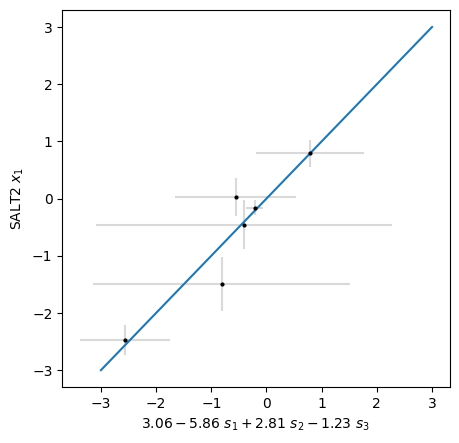

In [52]:
def find_best_rot(encoding, encoding_var, target):
    def apply_rot(coefs, x):
        return coefs @ x[1:] + x[0]

    def to_min(x):
        rot = apply_rot(encoding, x)
        return np.sum((rot - target)**2)

    res = minimize(to_min, np.zeros(encoding.shape[1] + 1))

    rot = apply_rot(encoding, res.x)
    rot_errs = np.sqrt(encoding_var @ (res.x[1:]**2))

    return res, rot, rot_errs

encoding_mu = np.array([ps_predictions['s1'], ps_predictions['s2'], ps_predictions['s3']]).T
encoding_err = np.array([ps_predictions['s1_error'], ps_predictions['s2_error'], ps_predictions['s3_error']]).T

res, rot, rot_errs = find_best_rot(
    encoding_mu[mask][good_salt_mask],
    encoding_err[mask][good_salt_mask]**2,
    salt_x1[good_salt_mask].data
)

plt.figure(figsize=(5, 5), dpi=100)
markers, caps, bars = plt.errorbar(rot, salt_x1[good_salt_mask], xerr=rot_errs, yerr=salt_x1_err[good_salt_mask], fmt='o', markersize=2, c='k')
[bar.set_alpha(0.15) for bar in bars]

print("Best fit:              ", res.x)
print("Pearson correlation:   ", np.corrcoef(rot, salt_x1[good_salt_mask])[0, 1]**2)
print("Difference RMS:        ", np.std(rot - salt_x1[good_salt_mask]))
print("Difference NMAD:       ", parsnip.utils.nmad(rot - salt_x1[good_salt_mask]))
print("Mean measurement error:", np.mean(salt_x1_err[good_salt_mask]))

x = res.x
plt.xlabel(f'${x[0]:.2f} {x[1]:+.2f}~s_1 {x[2]:+.2f}~s_2 {x[3]:+.2f}~s_3$')

# plt.xlabel('Rotation of Parsnip latent space')
plt.ylabel('SALT2 $x_1$')
plt.plot([-3, 3], [-3, 3])

plt.savefig('./figures/salt_x1_comparison.pdf')
